# Transfer learning example
From the [Chapter 14](https://github.com/ageron/handson-ml3/blob/main/14_deep_computer_vision_with_cnns.ipynb) notebook by Aurélien Geron.

In [8]:
import tensorflow as tf
import tensorflow_datasets as tfds
import matplotlib.pyplot as plt

dataset, info = tfds.load("tf_flowers", as_supervised=True, with_info=True)
dataset_size = info.splits["train"].num_examples
class_names = info.features["label"].names
n_classes = info.features["label"].num_classes

print(dataset_size)
print(class_names)

3670
['dandelion', 'daisy', 'tulips', 'sunflowers', 'roses']


In [9]:
# splitsies
test_set_raw, valid_set_raw, train_set_raw = tfds.load(
    "tf_flowers",
    split=["train[:10%]", "train[10%:25%]", "train[25%:]"],
    as_supervised=True)

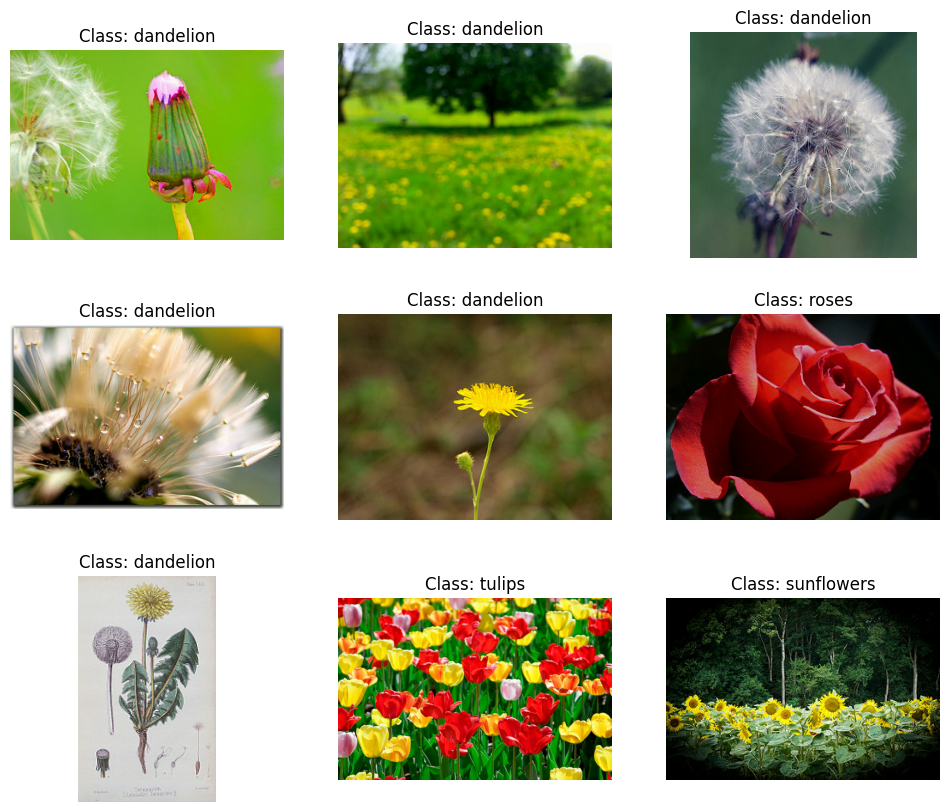

In [10]:
# extra code – displays the first 9 images in the validation set
plt.figure(figsize=(12, 10))
index = 0
for image, label in valid_set_raw.take(9):
    index += 1
    plt.subplot(3, 3, index)
    plt.imshow(image)
    plt.title(f"Class: {class_names[label]}")
    plt.axis("off")

plt.show()

We need to preprocess this to work with the transfer learning model (Xception). There's some magic going on in [tf.keras.applications.xception.preprocess_input](https://github.com/keras-team/keras/blob/v3.3.3/keras/src/applications/xception.py#L336-L340), which is ultimately a wrapper on [tf.keras.applications.imagenet_utils.preprocess_input](https://www.tensorflow.org/api_docs/python/tf/keras/applications/imagenet_utils/preprocess_input) with `mode="tf"`.

In [11]:
# Preprocess by resizing, then xception preprocessing
batch_size = 32
preprocess = tf.keras.Sequential([
    tf.keras.layers.Resizing(height=224, width=224, crop_to_aspect_ratio=True),
    tf.keras.layers.Lambda(tf.keras.applications.xception.preprocess_input)
])
train_set = train_set_raw.map(lambda X, y: (preprocess(X), y))
train_set = train_set.shuffle(1000, seed=42).batch(batch_size).prefetch(1)
valid_set = valid_set_raw.map(lambda X, y: (preprocess(X), y)).batch(batch_size)
test_set = test_set_raw.map(lambda X, y: (preprocess(X), y)).batch(batch_size)

In [12]:
# also define an augmentation layer
data_augmentation = tf.keras.Sequential([
    tf.keras.layers.RandomFlip(mode="horizontal", seed=42),
    tf.keras.layers.RandomRotation(factor=0.05, seed=42),
    tf.keras.layers.RandomContrast(factor=0.2, seed=42)
])

In [13]:
# load the Xception model with imagenet-trained weights
tf.random.set_seed(42)  # extra code – ensures reproducibility
base_model = tf.keras.applications.xception.Xception(weights="imagenet",
                                                     include_top=False)

# don't re-train the base model layers
for layer in base_model.layers:
    layer.trainable = False

# Define a few new layers for our new head, using the functional api
avg = tf.keras.layers.GlobalAveragePooling2D()(base_model.output)
output = tf.keras.layers.Dense(n_classes, activation="softmax")(avg)
model = tf.keras.Model(inputs=base_model.input, outputs=output)

83683744/83683744 ━━━━━━━━━━━━━━━━━━━━ 7s 0us/step


In [14]:
# train our new head
optimizer = tf.keras.optimizers.SGD(learning_rate=0.1, momentum=0.9)
model.compile(loss="sparse_categorical_crossentropy", optimizer=optimizer,
              metrics=["accuracy"])
history = model.fit(train_set, validation_data=valid_set, epochs=3)

Epoch 1/3
86/86 ━━━━━━━━━━━━━━━━━━━━ 110s 1s/step - accuracy: 0.7095 - loss: 0.8634 - val_accuracy: 0.8403 - val_loss: 0.5450
Epoch 2/3
86/86 ━━━━━━━━━━━━━━━━━━━━ 104s 1s/step - accuracy: 0.9193 - loss: 0.3039 - val_accuracy: 0.8784 - val_loss: 0.5436
Epoch 3/3
86/86 ━━━━━━━━━━━━━━━━━━━━ 115s 1s/step - accuracy: 0.9152 - loss: 0.2641 - val_accuracy: 0.8657 - val_loss: 0.5647


In [ ]:
# look at the model architecture
tf.keras.utils.plot_model(model)